# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

# Откройте файл с данными и изучите общую информацию

In [243]:
#Импортируем библиотеки
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

In [245]:
#Создаем датафафрейм
try: 
    data = pd.read_csv('real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [247]:
#Смотрим информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

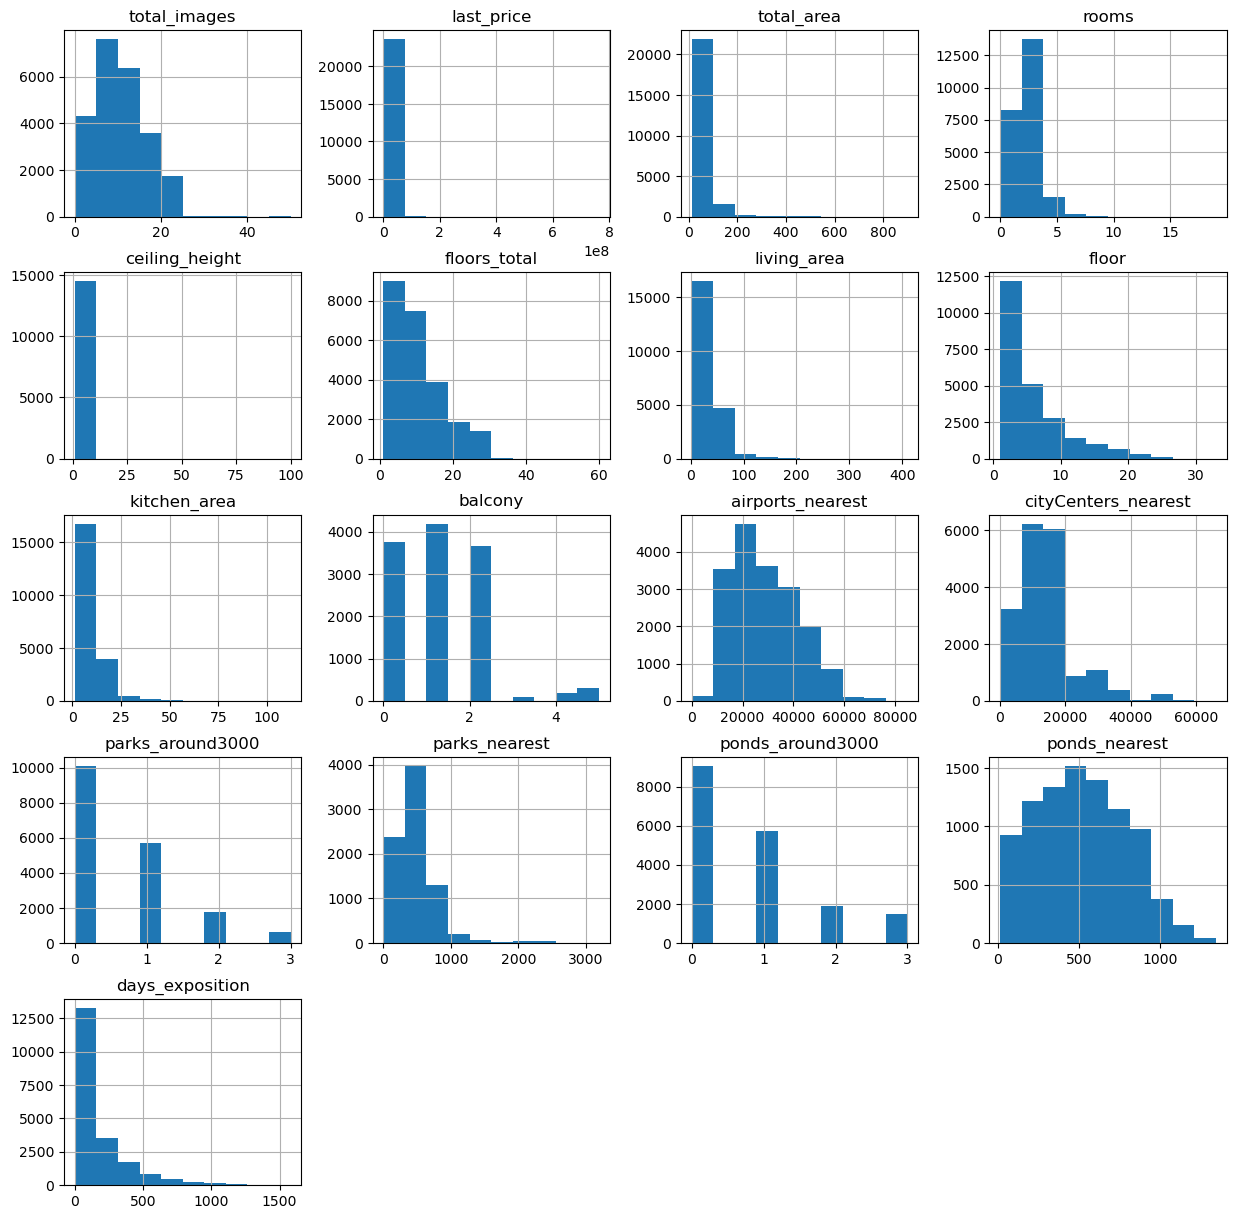

In [249]:
#Строим гистограмму для числовых столбцов
data.hist(figsize=(15, 15));

* Всего 23699 строк, 21 колонка, объем занимаемой памяти:3.7 МВ. 

* Видим, что есть пропуски в числовых значениях данных:
1. ceiling_height:           9195
2. floors_total:               86
3. living_area:              1903
4. is_apartment:            20924
5. kitchen_area             2278
6. balcony                 11519
7. locality_name              49
8. airports_nearest         5542
9. city_centers_nearest     5519
10. parks_around_three       5518
11. parks_nearest           15620
12. ponds_around_three       5518
13. ponds_nearest           14589
14. days_exposition          3181

* Большинство значений имеют тип float64, есть значения типа int64, bool и object, некоторые значения с плавающей точкой стоит изменить на целочисленные, например 'balcony', 'last_price', 'airports_nearest', first_day_exposition необходимо изменить на тип datetime


* Оценив гистограммы, мы видим, что многие из них имеют большое количество значений около нуля, некотрые имеют столбчаютую структуру, например, 'last_price' и 'balcony' а некоторые имеют положительную ассиметрию, например 'floors_total' и 'floor'  необходимо укрупнить и разобрать отдельные столбцы, предварительно заполнив пропуски 

## Предобработка данных

In [252]:
#Смотрим первые 5 строк таблицы
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


* Мы наблюдаем, что названия столбоцв: 'cityCenters_neares', 'parks_around3000', 'ponds_around3000' не соответствуют змеиному регистру, изменим их

In [254]:
data.rename(columns = {'cityCenters_nearest':'city_centers_nearest', 'parks_around3000':'parks_around_three', 'ponds_around3000':'ponds_around_three'}, inplace = True)

**Названия столбцов обработаны**

### Обработка пропусков

* Проверяем количество пропусков в данных

In [258]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_three       5518
parks_nearest           15620
ponds_around_three       5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Видим пропуски в значених высоты потолков, этажей в доме, жилая площадь, апартаменты, площадь кухни, количество балконов, название населенного пункта, расстояние до аэропорта, расстояние до центра города, числа парков в расстоянии 3км, расстоянии до ближайшего парка, числа озер в расстоянии 3км, расстоянии до ближайшего озера, количестве дней размещения объявления. 

Пропуски могли возникнуть:

* В следствии человеческой ошибки, например, случайный пропуск данных при внесение пользователем 
* В следствии технической ошибки, например, ошибка при выгрузке картографических данных

* Для заполнения числовых столбцов проверим корреляцию значений в столбцах между собой

In [261]:
data.corr()

ValueError: could not convert string to float: '2019-03-07T00:00:00'

1. Пойдем по порядку и обработаем столбец с высотой потолков. Явной корреляции между высотой потолков и другими параметрами мы не наблюдаем, поэтому заполним отсуствующие данные медианным значением

In [264]:
#пропуск в высоте потолоков заменяем на медианное значение 
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)

2. Пропусков в общем количестве этаже менее 1%, удалим их

In [267]:
#пропуск в floors_total на медианное значение 
data.dropna(subset=['floors_total'], inplace=True)

3.  Проверим кореляцию жилой площади, относительно количества комнат. Она почти равна 0.84. Медианой заполним пропуски жилой площади относительно количества комнат.

In [270]:
#пропуск в жилой площади, заполняем средним значением относительно общей площади
for t in data['total_area'].unique():
    data.loc[(data['total_area'] == t) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['total_area'] == t), 'living_area'].median()

In [272]:
#остались незаполненные значения, в целом, это могут быть нежилые объекты, например, коммерческая недвижемость, заполним их нулями
data['living_area'].fillna(0, inplace=True)

5. Мы видим, что наибольшая зависимость у кухонь, от общей площади, заполним пропуски относительного этой корреляции. Для того, чтобы заполнить пропуски по кухне, для начала заполним нулями пустые значения для студий

In [275]:
#пропуск площади кухни, заполняем 0, если квартира -- студия
for t in data['studio'].unique():
    data.loc[(data['studio'] == t) & (data['kitchen_area'].isna()), 'kitchen_area'] = 0

In [277]:
#пропуск площади кухни, заполняем медианой относительно общей площади
for t in data['total_area'].unique():
    data.loc[(data['total_area'] == t) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['total_area'] == t), 'kitchen_area'].median()

6. Сильной кореляции между количеством балконов и другими показателями не наблюдается, можно предположить, что большинство квартир просто неимеют балконы, заменим нулями

In [279]:
data['balcony'].fillna(0, inplace=True)

7. Узнать название локации не представляется возможным, также их менее 1%, удалим данные значения

In [281]:
data.dropna(subset=['locality_name'], inplace=True)

8. Значения в колонках 'расстояние до аэропорта', 'расстояние до центра города', 'числа парков в расстоянии 3км', 'расстоянии до ближайшего парка', 'числа озер в расстоянии 3км', 'расстоянии до ближайшего озера' заменим на 0, потому что невозможно определить данные параметры, либо они могут быть вовсе пустыми

In [283]:
data['airports_nearest'].fillna(0, inplace=True)
data['city_centers_nearest'].fillna(0, inplace=True)
data['parks_around_three'].fillna(0, inplace=True)
data['parks_nearest'].fillna(0, inplace=True)
data['ponds_around_three'].fillna(0, inplace=True)
data['ponds_nearest'].fillna(0, inplace=True)

9. Вероятнее всего пропущенные значения в колонке 'days_exposition' говорят нам о том, что объявление еще не снято с продаже, квартиры еще продаются, таких данных очень много, оставим без изменения, также поступим с данными об апартаментах

In [289]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest            0
city_centers_nearest        0
parks_around_three          0
parks_nearest               0
ponds_around_three          0
ponds_nearest               0
days_exposition          3171
dtype: int64

**Пропуски обработаны**

### Обработка типов данных

In [293]:
#Смотрим типы данных
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
city_centers_nearest    float64
parks_around_three      float64
parks_nearest           float64
ponds_around_three      float64
ponds_nearest           float64
days_exposition         float64
dtype: object

1. Приведем значения с плавающей точкой к целочисленным значениям там, где это необходимо

In [296]:
data['last_price'] = data['last_price'].astype('int') 
data['floors_total'] = data['floors_total'].astype('int') 
data['balcony'] = data['balcony'].astype('int') 
data['city_centers_nearest'] = data['city_centers_nearest'].astype('int') 
data['airports_nearest'] = data['airports_nearest'].astype('int') 
data['parks_around_three'] = data['parks_around_three'].astype('int') 
data['ponds_around_three'] = data['ponds_around_three'].astype('int') 
data['ponds_nearest'] = data['ponds_nearest'].astype('int') 
data['parks_nearest'] = data['parks_nearest'].astype('int') 

2. Приведем столбец с датой к типу дата

In [299]:
data['first_day_exposition'] = data['first_day_exposition'].astype('datetime64[ns]')

In [301]:
#Проверим обновеленные типы данных
data.dtypes

total_images                     int64
last_price                       int32
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int32
living_area                    float64
floor                            int64
is_apartment                    object
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int32
locality_name                   object
airports_nearest                 int32
city_centers_nearest             int32
parks_around_three               int32
parks_nearest                    int32
ponds_around_three               int32
ponds_nearest                    int32
days_exposition                float64
dtype: object

In [303]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_three,parks_nearest,ponds_around_three,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,...,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,NaN
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,NaN,...,11.0,2,посёлок Шушары,12817,18603,0,0,0,0,81.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,NaN,...,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,95.0,9,NaN,...,0.0,0,Санкт-Петербург,28098,6800,2,84,3,234,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,...,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121.0


**Типы данных обработаны**

### Ищем дубликаты

In [307]:
#Ищем явные дубликаты
data.duplicated().sum()

0

**Явных дубликатов не найдено**

In [310]:
#Проверяем уникальные значения для наименований населнных пунктов
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

*Наблюдаем неявные дубликаты, напишем функцию для приведения названий к единому стилю*

In [313]:
def rename_village(row):
    #Пишем регулярное выражение, которое ищет в строке слово, которое начинается с заглавной буквы
    words = re.search(r'\b[А-ЯЁ][а-яё]*\b', row)
    
    #Пишем условия для поиска заменяемых строк и изменения их
    if 'пос' in row:
        return f'поселок {words.group()}'
    elif 'сад' in row:
        return f'садовое товарищество {words.group()}'      
    else:
        return row
        

In [315]:
#Забеняем названия в исходном столбце
data['locality_name'] = data['locality_name'].apply(rename_village)

In [317]:
#Смотрим результат
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_three,parks_nearest,ponds_around_three,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,...,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,NaN
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,NaN,...,11.0,2,поселок Шушары,12817,18603,0,0,0,0,81.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,NaN,...,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,95.0,9,NaN,...,0.0,0,Санкт-Петербург,28098,6800,2,84,3,234,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,...,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121.0


In [319]:
#Смотрим результат
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка

**Дубликаты удалены**

## Добавьте в таблицу новые столбцы

1. Добавляем столбец цена квадратного метра, округляем до двух знаков

In [324]:
data['price_square'] = data['last_price']/data['total_area']
data['price_square'] = data['price_square'].round(2)

2. Добавляем столбец с днем недели публикации объявления

In [327]:
data['weekday_publication'] = data['first_day_exposition'].dt.weekday

3. Добавляем столбец с месяцем публикации объявления

In [330]:
data['month_publication'] = data['first_day_exposition'].dt.month

4. Добавляем столбец с годом публикации объявления

In [333]:
data['year_publication'] = data['first_day_exposition'].dt.year

5. Добавляем столбец с типом этажа квартиры

In [336]:
def creating_floor_type(row):
    
    floors_total = row['floors_total']
    floor = row['floor']
    
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'


In [338]:
data['floors_type'] = data.apply(creating_floor_type, axis=1)

6. Добавляем столбец с расстоянием до центра города в километрах

In [341]:
data['city_centers_nearest_km'] = data['city_centers_nearest']/1000
data['city_centers_nearest_km'] = data['city_centers_nearest_km'].astype('int')                                       

In [343]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around_three,ponds_nearest,days_exposition,price_square,weekday_publication,month_publication,year_publication,floors_type,city_centers_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,...,482,2,755,NaN,120370.37,3,3,2019,другой,16
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,NaN,...,0,0,0,81.0,82920.79,1,12,2018,первый,18
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,NaN,...,90,2,574,558.0,92785.71,3,8,2015,другой,13
3,0,64900000,159.0,2015-07-24,3,2.65,14,95.0,9,NaN,...,84,3,234,424.0,408176.10,4,7,2015,другой,6
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,...,112,1,48,121.0,100000.00,1,6,2018,другой,8


**Столбцы добавлены**

## Проведите исследовательский анализ данных

### Изучаем параметры

1. Общая площадь

Построим "ящик с усами", чтобы определить аномальные значения 

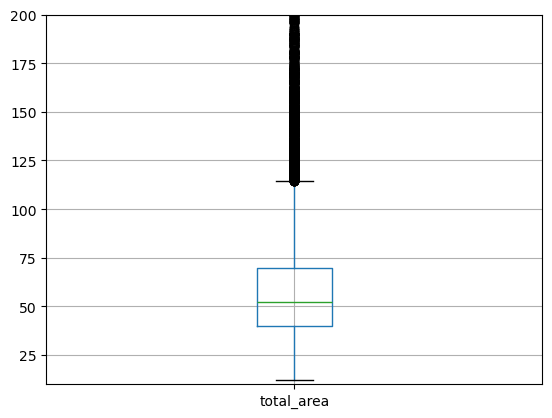

In [350]:
plt.ylim(10, 200)
data.boxplot(column='total_area', figsize=(6, 6));

Мы видим, что верхний "ус" заканчивается в районе 115, все что находится за ним, не будем учитывать в выборкe, также не наблюдаем значений менее 10

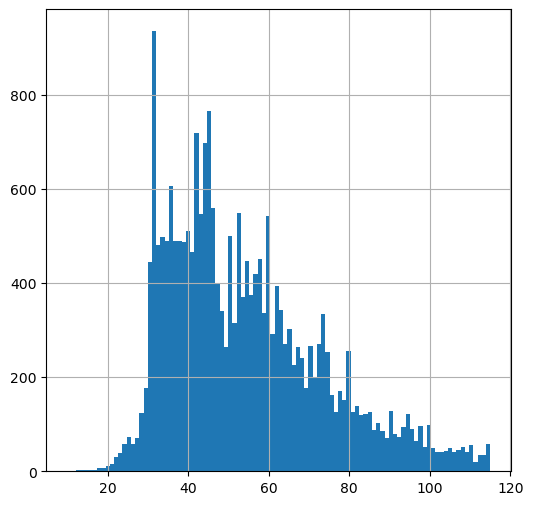

In [353]:
data['total_area'].hist(bins=100, range=(10, 115), figsize=(6, 6), grid=True);

**Из постронной гистрограммы видно, что чаще других продавали квартиры площадью 32 квадратных метра**

2. Жилая площадь

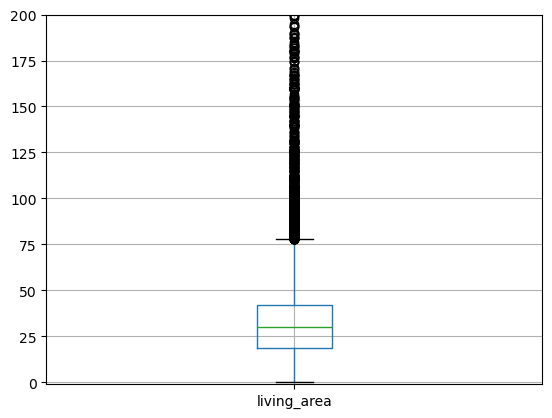

In [357]:
plt.ylim(-1, 200)
data.boxplot(column='living_area', figsize=(6, 6));

Мы видим, что верхний "ус" заканчивается в районе 75, все что находится за ним, не будем учитывать в выборкe

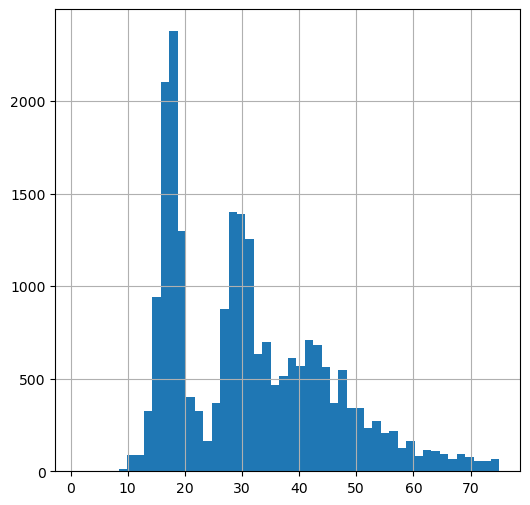

In [360]:
data['living_area'].hist(bins=50, range=(1, 75), figsize=(6, 6), grid=True);

**Мы видим, что пик жилой площади находится в диапазоне 17-18 квадратных метров, более 2000 квартир, в промежутке 20-30 квадратных метров, мы видим просадку по жилой площади, далее пик на 31-32 квадратных метрах, предположу, что это связано с распределение площади квартиры относительно количества комнат в ней. Первый пик -- однокомнатные квартиры, второй -- двухкомнатные.**

In [363]:
#Проверим данную гепотизу
data.pivot_table(index='rooms', values='living_area')

,living_area
rooms,
0,18.648041
1,18.012609
2,31.690259
3,47.172216
4,66.099403
5,96.124631
6,126.925769
7,153.864661
8,168.683333


3. площадь кухни

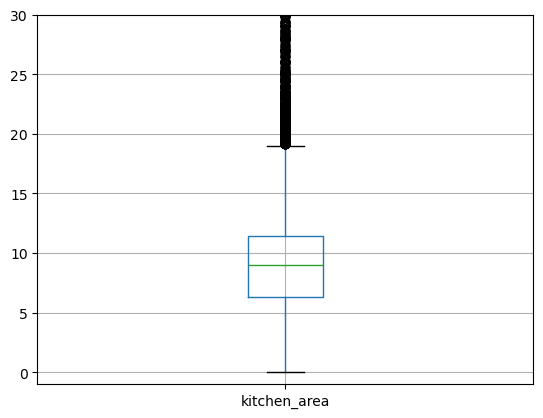

In [366]:
plt.ylim(-1, 30)
data.boxplot(column='kitchen_area', figsize=(6, 6));

Все что больше 20 выбросы

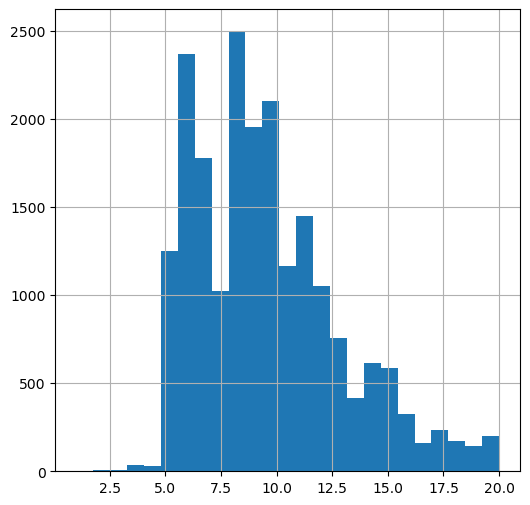

In [369]:
data['kitchen_area'].hist(bins=25, range=(1, 20), figsize=(6, 6), grid=True);

**Больше всего было продано квартир с площадью кухни 8 квадратных метров**

4. стоимость квартиры

In [373]:
#Проверим искажения в стоимости
data.pivot_table(index='last_price', values='total_area').head(20)

,total_area
last_price,
12190,109.000000
430000,42.200000
440000,40.000000
450000,40.100000
470000,40.833333
480000,32.000000
490000,34.550000
500000,38.675000
520000,30.000000


In [375]:
#Напишем функцию, которая исправляет искажения
def norm_price(row):
    
            
    if row < 100000:
        return row*1000
    elif row < 1000000:
        return row*10
    else:
        return row

In [377]:
data['last_price'] = data['last_price'].apply(norm_price)

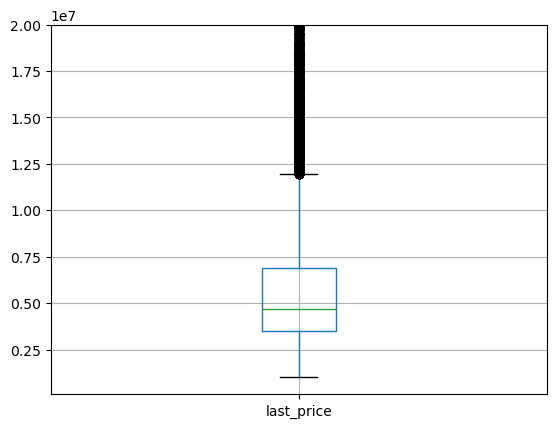

In [385]:
plt.ylim(100000, 20000000)
data.boxplot(column='last_price', figsize=(6, 6));

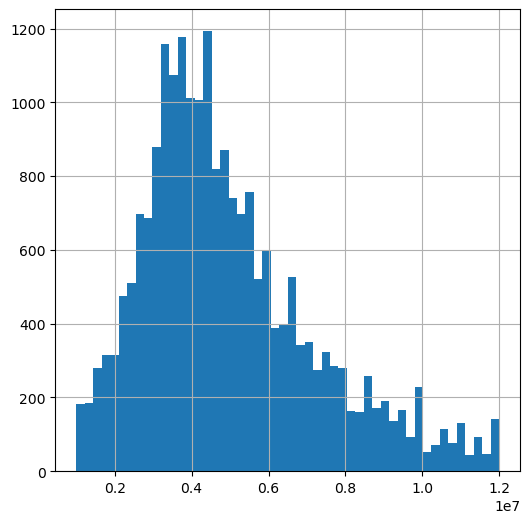

In [387]:
data['last_price'].hist(bins=50, range=(1000000, 12000000), figsize=(6, 6), grid=True);

**Чаще всего продавались квартиры стоимостью около 4 000 000 рублей**

5. Число комнат

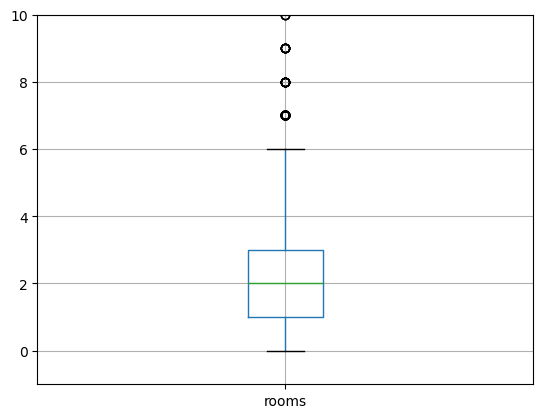

In [391]:
plt.ylim(-1, 10)
data.boxplot(column='rooms', figsize=(6, 6));

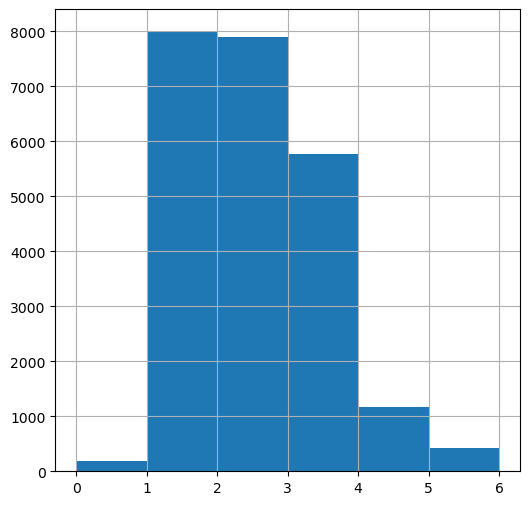

In [393]:
data['rooms'].hist(bins=6, range=(0, 6), figsize=(6, 6), grid=True);

**Чаще других продавались квартиры, в которых 1-3 комнаты**

6. Высота потолков

In [397]:
#Смотрим уникальные значения
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

In [399]:
#Обрабатываем их
def creating_ceiling_height(row):
    
            
    if row == 20.0:
        return '2.0'
    elif row == 22.6:
        return '2.26'
    elif row == 24.0:
        return '2.4'
    elif row == 25.0:
        return '2.5'
    elif row == 26.0:
        return '2.6'
    elif row == 27.0:
        return '2.7'
    elif row == 27.5:
        return '2.75'
    elif row == 32.0:
        return '3.2'
    elif row == 100.0:
        return '10.0'
    else:
        return row

In [401]:
data['ceiling_height'] = data['ceiling_height'].apply(creating_ceiling_height)

In [403]:
data['ceiling_height'] = data['ceiling_height'].astype(float)

In [405]:
data['ceiling_height'].sort_values().unique()

array([ 1.  ,  1.2 ,  1.75,  2.  ,  2.2 ,  2.25,  2.26,  2.3 ,  2.34,
        2.4 ,  2.45,  2.46,  2.47,  2.48,  2.49,  2.5 ,  2.51,  2.52,
        2.53,  2.54,  2.55,  2.56,  2.57,  2.58,  2.59,  2.6 ,  2.61,
        2.62,  2.63,  2.64,  2.65,  2.66,  2.67,  2.68,  2.69,  2.7 ,
        2.71,  2.72,  2.73,  2.74,  2.75,  2.76,  2.77,  2.78,  2.79,
        2.8 ,  2.81,  2.82,  2.83,  2.84,  2.85,  2.86,  2.87,  2.88,
        2.89,  2.9 ,  2.91,  2.92,  2.93,  2.94,  2.95,  2.96,  2.97,
        2.98,  2.99,  3.  ,  3.01,  3.02,  3.03,  3.04,  3.05,  3.06,
        3.07,  3.08,  3.09,  3.1 ,  3.11,  3.12,  3.13,  3.14,  3.15,
        3.16,  3.17,  3.18,  3.2 ,  3.21,  3.22,  3.23,  3.24,  3.25,
        3.26,  3.27,  3.28,  3.29,  3.3 ,  3.31,  3.32,  3.33,  3.34,
        3.35,  3.36,  3.37,  3.38,  3.39,  3.4 ,  3.42,  3.43,  3.44,
        3.45,  3.46,  3.47,  3.48,  3.49,  3.5 ,  3.51,  3.52,  3.53,
        3.54,  3.55,  3.56,  3.57,  3.58,  3.59,  3.6 ,  3.62,  3.63,
        3.65,  3.66,

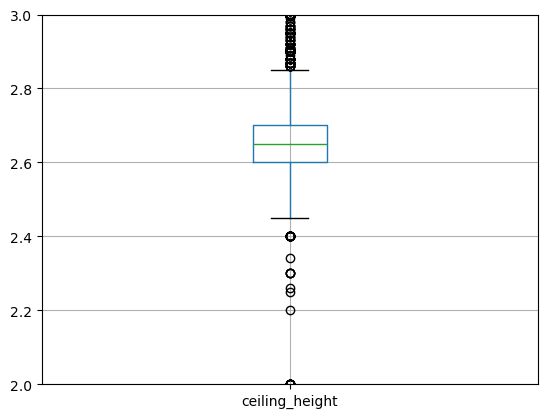

In [407]:
plt.ylim(2, 3)
data.boxplot(column='ceiling_height', figsize=(6, 6));

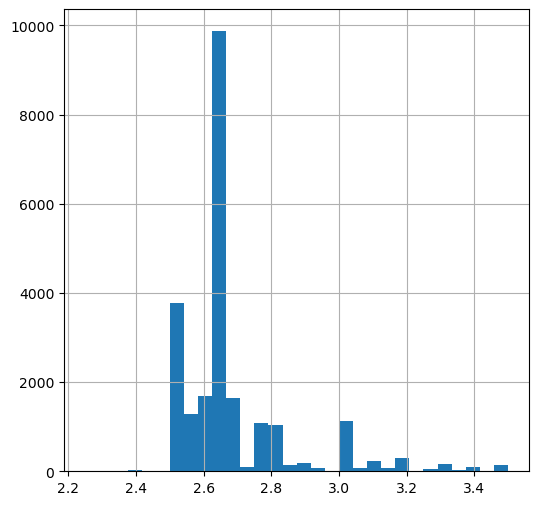

In [409]:
data['ceiling_height'].hist(bins=30, range=(2.25, 3.5), figsize=(6, 6), grid=True);

**Как правило высота потолка в квартире 2.7 метра**

7. Этаж на котором продавалась квартира

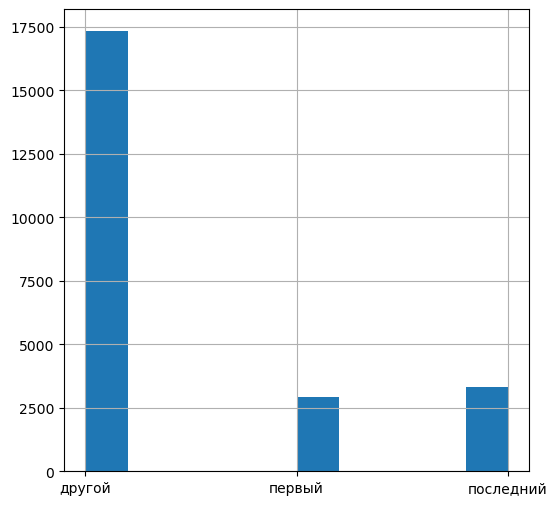

In [417]:
data['floors_type'].hist(figsize=(6, 6), grid=True);

**Квартир на первом этаже было продано чуть больше 2 тысяч, квартир на последнем этаже около трех тысяч, квартир на дригих этажаха около 15 тысяч**

8. Количество этажей в доме

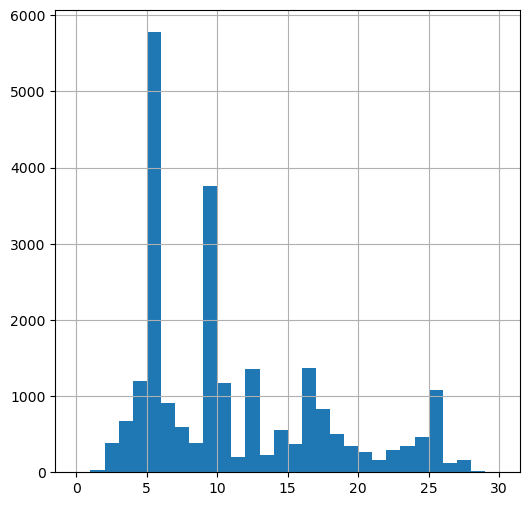

In [421]:
data['floors_total'].hist(bins=30, range=(0, 30), figsize=(6, 6), grid=True);

**Чаще других продавались квартиры в шестиэтажных домах**

9. Расстояние до центра города

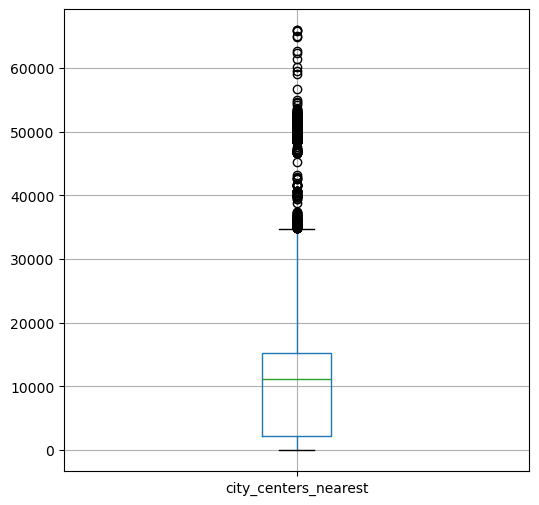

In [425]:
data.boxplot(column='city_centers_nearest', figsize=(6, 6), grid=True);

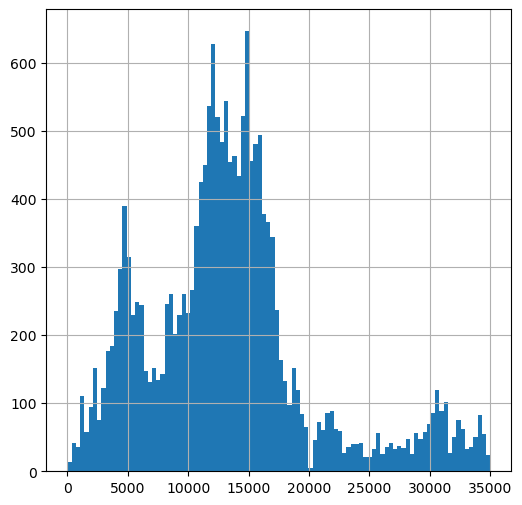

In [427]:
data['city_centers_nearest'].hist(bins=100, range=(1, 35000), figsize=(6, 6), grid=True);

**Большинство квартир было куплено в расстоянии 15 000 метров от центра города, в спальных районах**

10. Расстояние до парка

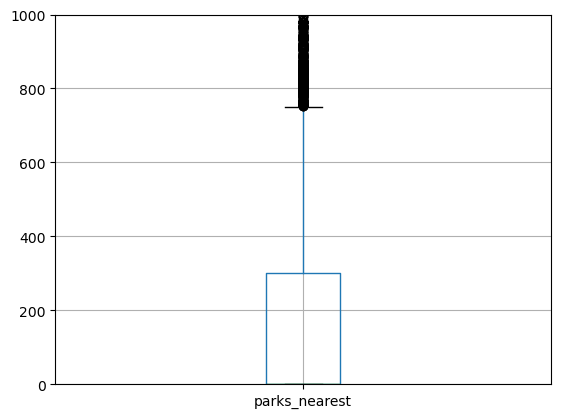

In [433]:
plt.ylim(0, 1000)
data.boxplot(column='parks_nearest', figsize=(6, 6), grid=True);

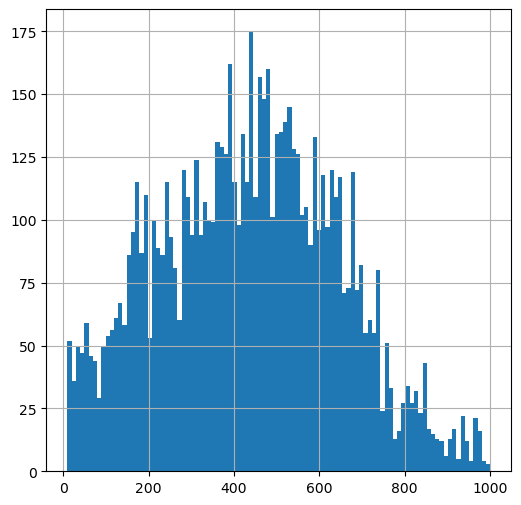

In [435]:
data['parks_nearest'].hist(bins=100, range=(10, 1000), figsize=(6, 6), grid=True);

**Рядом с большинство квартир есть парки в расстоянии менее 1 000 метров**

### Скорость продажи квартиры

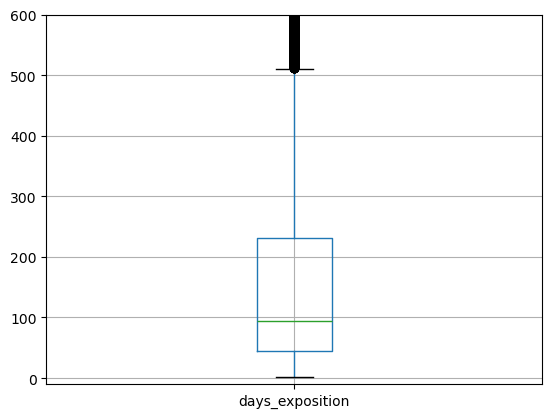

In [439]:
plt.ylim(-10, 600)
data.boxplot(column='days_exposition', figsize=(6, 6), grid=True);

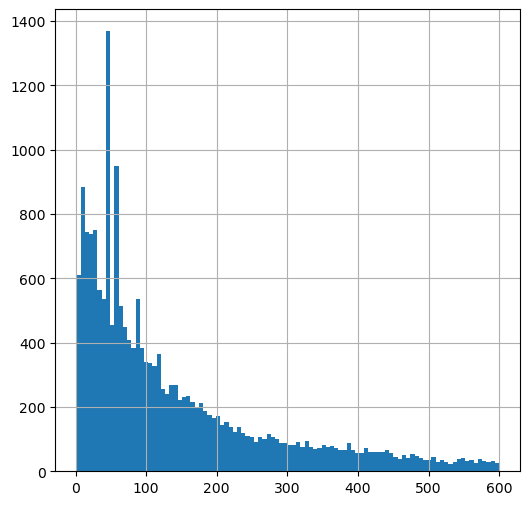

In [441]:
data['days_exposition'].hist(bins=100, range=(1, 600), figsize=(6, 6), grid=True);

In [443]:
data['days_exposition'].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

*Среднее - 180, медиана - 95*

**Большинство квартир продаются в промежутке от 45 до 231 дней, если квартира продается дольше, то можно считать, что это необычно долгая продажа, быстрыми можно считать продажи до 45 дней.**

### Факторы, влияющие на стоимость

1. Зависимость цены от площади

In [449]:
data['last_price'].corr(data['total_area'])

0.651352153390415

In [451]:
data.pivot_table(index='last_price', values='total_area').head(20)

,total_area
last_price,
1000000,40.585000
1010000,32.200000
1020000,47.600000
1030000,41.500000
1050000,41.816667
1060000,29.300000
1070000,38.550000
1080000,30.600000
1090000,35.575000


(10.0, 115.0)

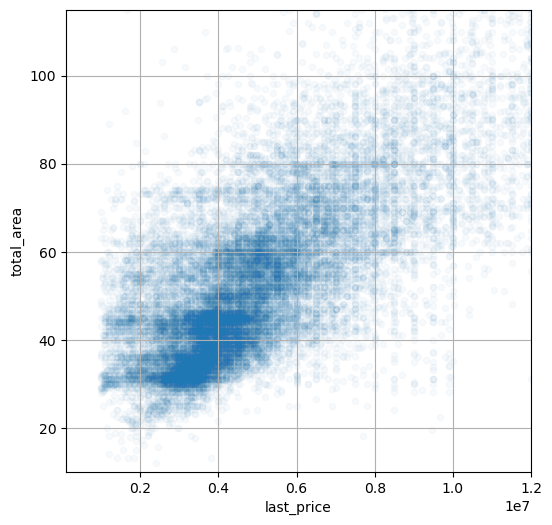

In [453]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.03, figsize=(6, 6), grid=True);      
plt.xlim(100000, 12000000)
plt.ylim(10, 115)

**На диаграмме рассеяния видно, что зависимость между ценой квартиры и ее площадью есть.**

2. Зависимость цены от жилой площади

In [457]:
data['last_price'].corr(data['living_area'])

0.5405107260560594

(0.0, 75.0)

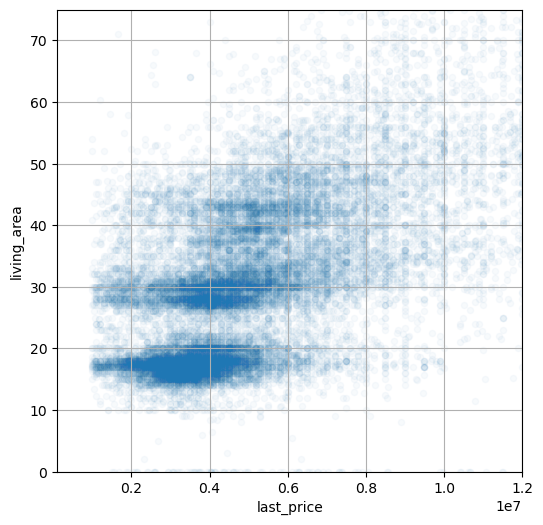

In [459]:
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.03, figsize=(6, 6), grid=True);
plt.xlim(100000, 12000000)
plt.ylim(0, 75)

**На диаграмме рассеяния видно, площадь жилой площади тоже влияет на цену квартиры, но меньше, чем общая площадь.**

3. Зависимость цены от площади кухни

In [463]:
data['last_price'].corr(data['kitchen_area'])

0.3842293252034849

(1.0, 20.0)

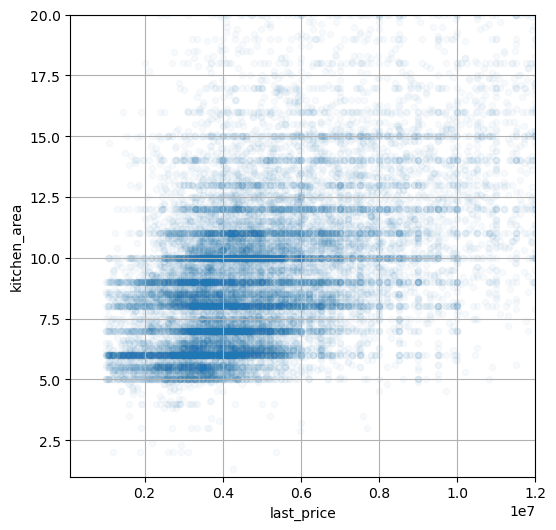

In [465]:
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.03, figsize=(6, 6), grid=True);
plt.xlim(100000, 12000000)
plt.ylim(1, 20)

**На диаграмме рассеяния видно, что не смотря на небольшую зависимость, площадь кухни не явно влияет на стоимость квартиры**

4. Зависимость цены от количества комнат

(100000.0, 12000000.0)

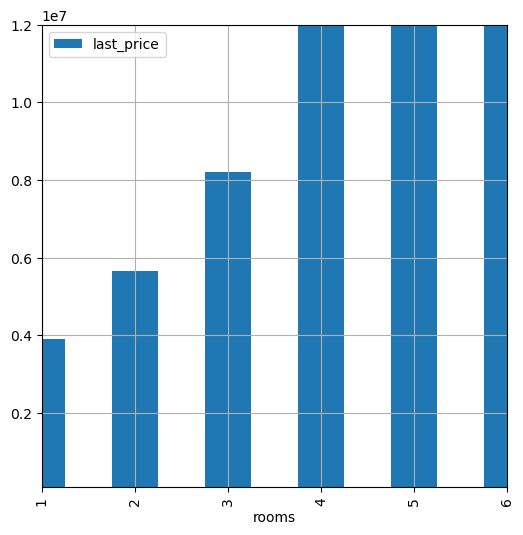

In [469]:
data.pivot_table(index='rooms', values='last_price').plot(y='last_price', kind='bar', figsize=(6, 6), grid=True); 
plt.xlim(1, 6)                                                                        
plt.ylim(100000, 12000000)                                                                          

**На столбчатой диаграмме видно, что чем больше комнат, тем больше стоимость недвижимости**

5. Зависимость цены от этажа

(100000.0, 12000000.0)

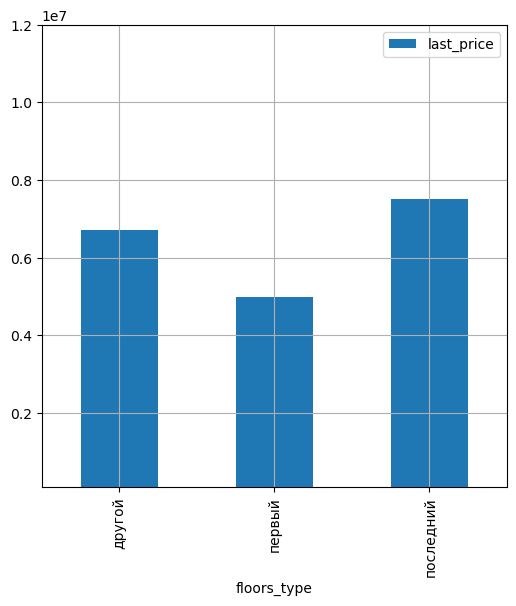

In [473]:
data.pivot_table(index='floors_type', values='last_price').plot(y='last_price', kind='bar', figsize=(6, 6), grid=True);                                                                  
plt.ylim(100000, 12000000)   

**На столбчатой диаграмме видно, что на первых этажах самая низкая стоимость недвижимости, а на последних самая высокая**

6. Зависимость цены от дня недели публикации

(100000.0, 12000000.0)

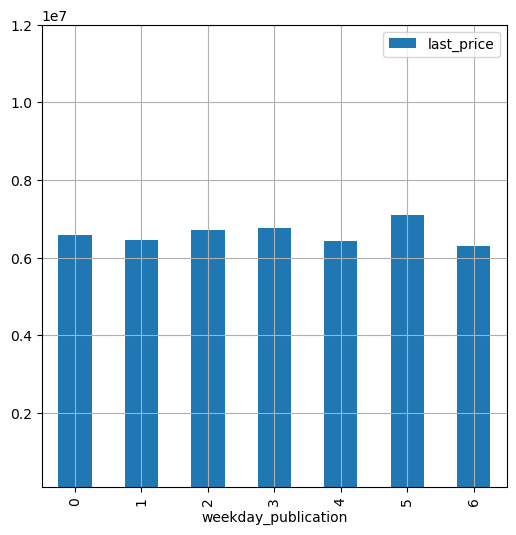

In [477]:
data.pivot_table(index='weekday_publication', values='last_price').plot(y='last_price', kind='bar', figsize=(6, 6), grid=True);                                                                     
plt.ylim(100000, 12000000)  

**На столбачтой диаграмме видно, что средняя стоимость объявления относительно дня недели публикации, отличается не сильно, какой-то отчетливой зависимости нет, по субботам в среднем публикуют самые дорогие объявления**

6. Зависимость цены от месяца публикации

(100000.0, 12000000.0)

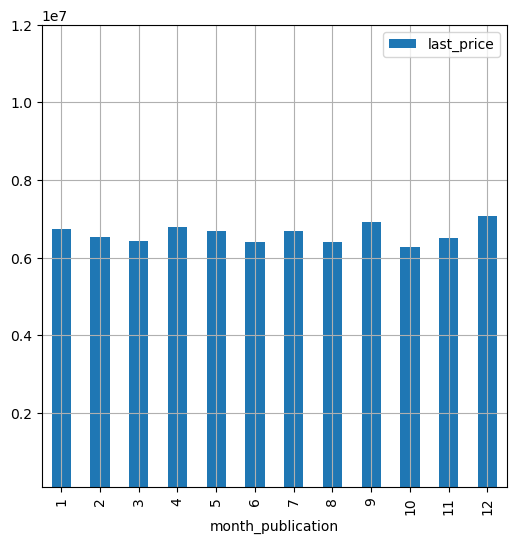

In [481]:
data.pivot_table(index='month_publication', values='last_price').plot(y='last_price', kind='bar', figsize=(6, 6), grid=True);                                                                    
plt.ylim(100000, 12000000)  

**На столбачтой диаграмме видно, что средняя цена недвижемости относительно месяца публикации держится в районе чуть более 6 млн, с пиками в районе 7 000 000 в сентябре и декабре**

7. Зависимость цены от года публикации

(100000.0, 12000000.0)

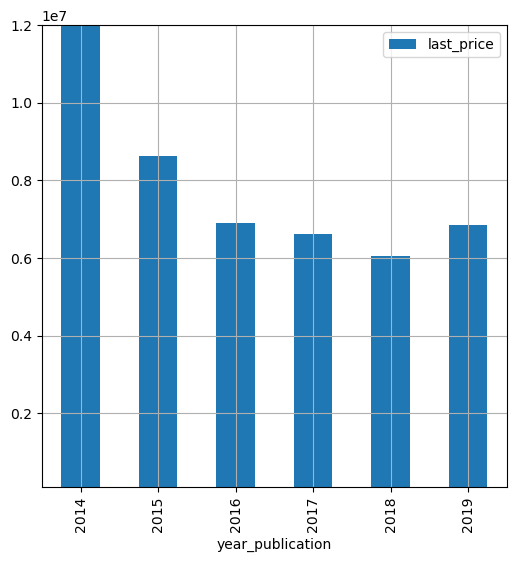

In [485]:
data.pivot_table(index='year_publication', values='last_price').plot(y='last_price', kind='bar', figsize=(6, 6), grid=True);                                                                     
plt.ylim(100000, 12000000)  

**На диаграмме рассеяния видно, что средняя стоимость опубликованного объявления с 2014 по 2018 год постепенно снижалась с 12 до 6 млн, в 2019 году мы наблюдаем увеличение стоимости средней стоимости публикации**

### Стоимость квадратного метра в населенных пунктах

In [502]:
#Сводная таблица для 10 пунктов с наибольшим числом объявлений
square_pivot = data.pivot_table(index='locality_name', values='price_square', aggfunc=['count', 'mean'])

square_pivot.columns = ['Количество объявлений', 'Средняя стоимость квадратного метра']

square_pivot.sort_values(by='Количество объявлений', ascending=False).head(10)

,Количество объявлений,Средняя стоимость квадратного метра
locality_name,,
Санкт-Петербург,15651,114868.877339
поселок Мурино,552,85629.568641
поселок Шушары,439,78551.344647
Всеволожск,398,68654.473970
Пушкин,369,103125.819377
Колпино,338,75424.579112
поселок Парголово,327,90175.913089
Гатчина,307,68746.146515
деревня Кудрово,299,92473.547559


**Ожидаемый результат -- город Санк-Петербург первый с большим отрывом по количеству объявлений.**

In [505]:
square_pivot.sort_values(by='Средняя стоимость квадратного метра', ascending=False).head(1)

,Количество объявлений,Средняя стоимость квадратного метра
locality_name,,
Зеленогорск,24,115122.799583


**Зеленогорск самый дорогой город по цене квадратного метра. Является курортным районом в Санкт-Петербурге, не удивительно, что средняя стоимость квадртного метра там выше всего.**

In [510]:
square_pivot.sort_values(by='Средняя стоимость квадратного метра', ascending=False).tail(1)

,Количество объявлений,Средняя стоимость квадратного метра
locality_name,,
деревня Старополье,3,11206.22


**Деревня Старполье один из самых маленьких населенных пунктов Ленинградской области, 823 человека на момент 2017 года, не удивительно, что мы  наблюдаем самую низкую стоимость квадратного метра в данном н/п.**

### Средняя стоимость квартиры в Санкт-Петербурге относительно удаленности от центра города

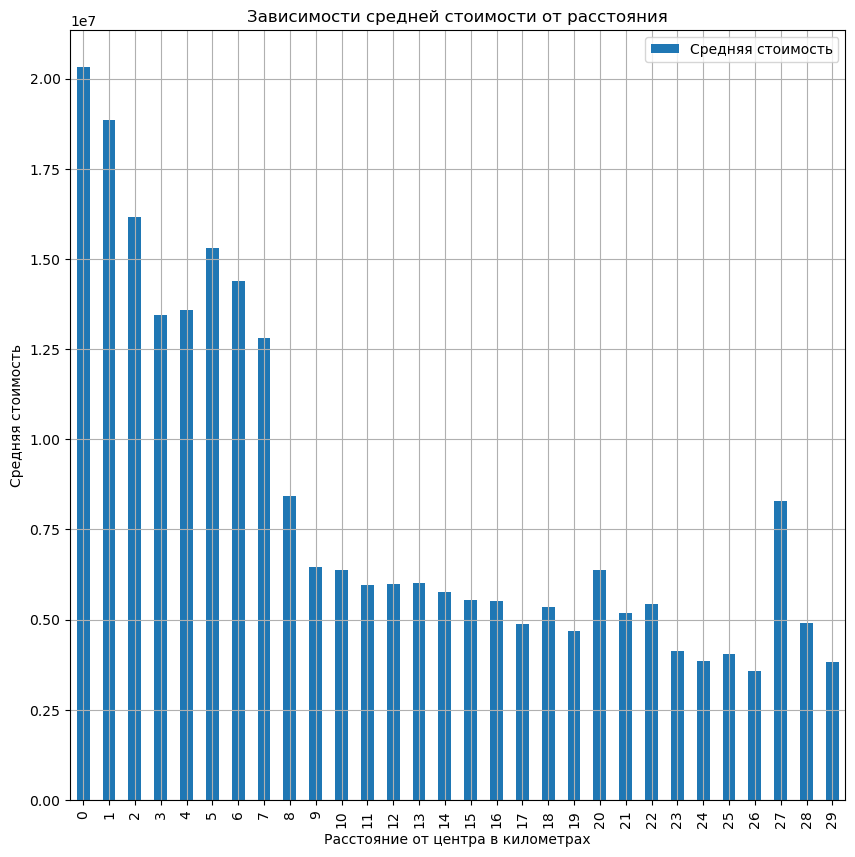

In [516]:
data_cultural_capital = data.query('locality_name == "Санкт-Петербург"')

data_cultural_capital_pivot = data_cultural_capital.pivot_table(index='city_centers_nearest_km', values='last_price').astype(int)

data_cultural_capital_pivot.columns = ['Средняя стоимость']

data_cultural_capital_pivot.plot(y='Средняя стоимость', kind='bar', grid=True, figsize=(10, 10), title='Зависимости средней стоимости от расстояния', xlabel='Расстояние от центра в километрах', ylabel='Средняя стоимость');

Исходя из анализа полученный таблицы можно сделать следующие выводы:
1. В центре города самая высокая средняя стоимость
2. При удалении от центра средняя стоимость в основном падает, за исключением нескольких отрезков
3. Есть аномальная позиция на 27 км, которая обладает слишком большой стоимостью, проверим ее, видим, что было продано всего 2 квартиры, в выборке можно не учитывать

In [519]:
data_cultural_capital['city_centers_nearest_km'].value_counts().tail()

city_centers_nearest_km
24    22
28    10
26     3
29     3
27     2
Name: count, dtype: int64

## Общий вывод

Мы получили задачу по определению рыночной стоимости объектов недвижимости. Нам были доступны данные, которые были собраны автоматически, а также те, что были вписаны пользователями.  

* Первым этапом выполнения работы было знакомство с данными и их предобработка:
1. Мы привели название колонок к змеиному регистру
2. Заполнили недостающие значения, где это возможно
3. Изменили тип данных, где это было необходимо
4. Привели значения к единому виду

* Далее мы добавили столбцы с необходимыми параметрами и получили
1. Цену квадратного метра
2. День недели, месяц и год публикации объявления
3. Тип этажа квартиры (Первый, последний, другой)
4. Расстояние до центра города в км

* Провели исследование данных и определили:

1. Построили гистограммы числовых параметров, исключив из них вбросы и обработов аномалии
2. Определили, как быстро продаются квартиры: Большинство квартир продаются в промежутке от 45 до 232 дней
3. Определили, какие параметры больше влияют на стоиомость квратиры:
*  Дороже будут стоить квартиры с большой общей и жилой площадью, находящиеся ближе к центру и расположенные на последнем этаже
*  Более дешевой будет недвижиомсть в спальных районах(удаленная от центра), с маленькими площадями, расположенная на первых этажах
4. Также мы узнали, что с 2014 года по 2018 существовала тенденция к снижению средней стоимости недвижимости, возможно это связано с увеличением количества объявлений на площадке, в качестве рекомендации могу предложить посчитать отношение количества объявлений к средней стоимости публикации год к году, чтобы в этом убедиться, в 2019 году мы увидели тенденцию к росту
5. Мы определили, что самая большая средняя стоимость одного квадратного метра в городе Санкт-Петербург, а самая низкая в деревне Старополье
6. Также нам стало очевидно, что чем ближе к центру Санкт-Петербурга, тем выше средняя стоимость квартиры

* Рекомендации:
1. Добавить строку с текущей датой выгрузки, чтобы в ячейках с количеством дней с момента публикации не было пустых значений
2. Можно добавить маски для некоторых числовых переменных, например высоты потолков и стоимости недвижимости, чтобы не было случаев с неправильным заполнением данных
3. Мы видим, что стоблец апартаменты практически полностью незаполнен, возможно стоит автоматически проставлять False в случае его незаполнения
4. Добавить столбец со стоимостью квадратного метра, который будет рассчитываться автоматически 
5. Непонятно насколько актуальны данные с количеством озер и расстоянием до них, возможно эти данные логичнее заменить на данные о торговых центрах, местах массовых мероприятий, общепита и т.п.